## Dependencies

In [1]:
#%% dependencies
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ML and AI
from sklearn.preprocessing import StandardScaler

# Custom LSTM Model + LRP
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # to surpress Tensorflow debugging warnings that arise in jupyter notebooks
from LSTM2 import *
from Preprocessing import process_data_with_factors, prepare_data_for_training

# Plotting and Graphs
import plotly.graph_objects as go

LSTM Load Dependencies: DONE ✔️




## Preprocessing Factor Data

In [2]:
# Define Path to File with factors
file_path = "./data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)

# Take the data frame and compute a data set of batches of size corresponding to a rolling time-step window of 5
X_train, y_train, X_test, y_test = prepare_data_for_training(data=sp500, small_window_size=5, split_ratio=1)
print("Preprocessing: DONE ✔️")

Download data from yahoo finance ...
[*********************100%***********************]  1 of 1 completed
Download: DONE ✔️
Preprocessing: DONE ✔️


## Build Deep Factor Model Archtecture

In [5]:
# ----------------------------- MODEL CONSTRUCTION ----------------------------------
timesteps = 5
input_dim = len(sp500.columns) - 1
input_shape = (timesteps, input_dim)
from keras.layers import Bidirectional, LSTM

input_layer = Input(shape=input_shape, name="Input")
lstm_output2 = Bidirectional(LSTM(units=16, return_sequences=False,
                                                      return_state=False,
                                                      kernel_initializer='glorot_uniform',
                                                      kernel_regularizer=L2(0.01),
                                                      name="CustomLSTM_2"))(input_layer)
output_layer = Dense(1, activation='linear', kernel_initializer='glorot_uniform',
                     kernel_regularizer=L2(0.01), name="Dense_2_Final")(lstm_output2)

# Create the model
model = CustomModel(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print the model summary
model.summary()
# ----------------------------- END: MODEL CONSTRUCTION ----------------------------------
print("Creating model architecture: DONE ✔️")

ValueError: Layer "Dense_2_Final" expects 1 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor 'Placeholder:0' shape=(None, 32) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(None, 16) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 16) dtype=float32>, <tf.Tensor 'Placeholder_3:0' shape=(None, 16) dtype=float32>, <tf.Tensor 'Placeholder_4:0' shape=(None, 16) dtype=float32>]

In [44]:
# def reset_weights(model, init_weights):
#     new_weights=[]
#     for i, l in enumerate(init_weights):
#         print(l)
        
#         s = init_weights[i].shape
#         print(s)
        
#         new_weights.append(l.kernel_initializer(s))
#     return new_weights
    

# # print(model.get_weights())
# init_weights = model.get_weights()
# print(reset_weights(model,init_weights))

# # model.set_weights(reset_weights(model,init_weights))
# len(model.get_weights)

10

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 14)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3968      
 l)                                                              
                                                                 
 Dense_2_Final (Dense)       (None, 1)                 33        
                                                                 
Total params: 4,001


Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________

Starting rolling window fitting...



 50%|█████     | 1/2 [00:07<00:07,  7.69s/it]

100%|██████████| 2/2 [00:15<00:00,  7.67s/it]


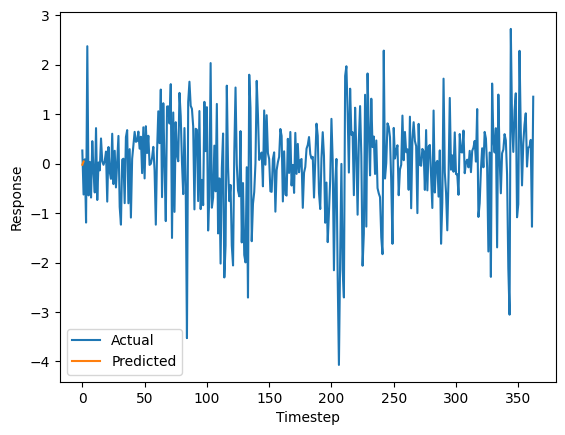

Rolling window fitting completed.


ValueError: operands could not be broadcast together with shapes (2,) (363,) 

In [4]:

# Fit rolling lstm model
predictions, relevance = rolling_fit(input_layer=input_layer, output_layer=output_layer,X_train=X_train, y_train=y_train)

# Compute mse
mse = np.mean((predictions - y_train[60:])**2)

print("The MSE of the model:\t", mse)

In [19]:
print("The MSE of the model:\t", mse)

The MSE of the model:	 1.429593906537701


In [7]:
np.mean(y_train[60:]**2)

0.9193112278273102

Text(0.5, 1.0, 'Factor Relevance (averaged over time)')

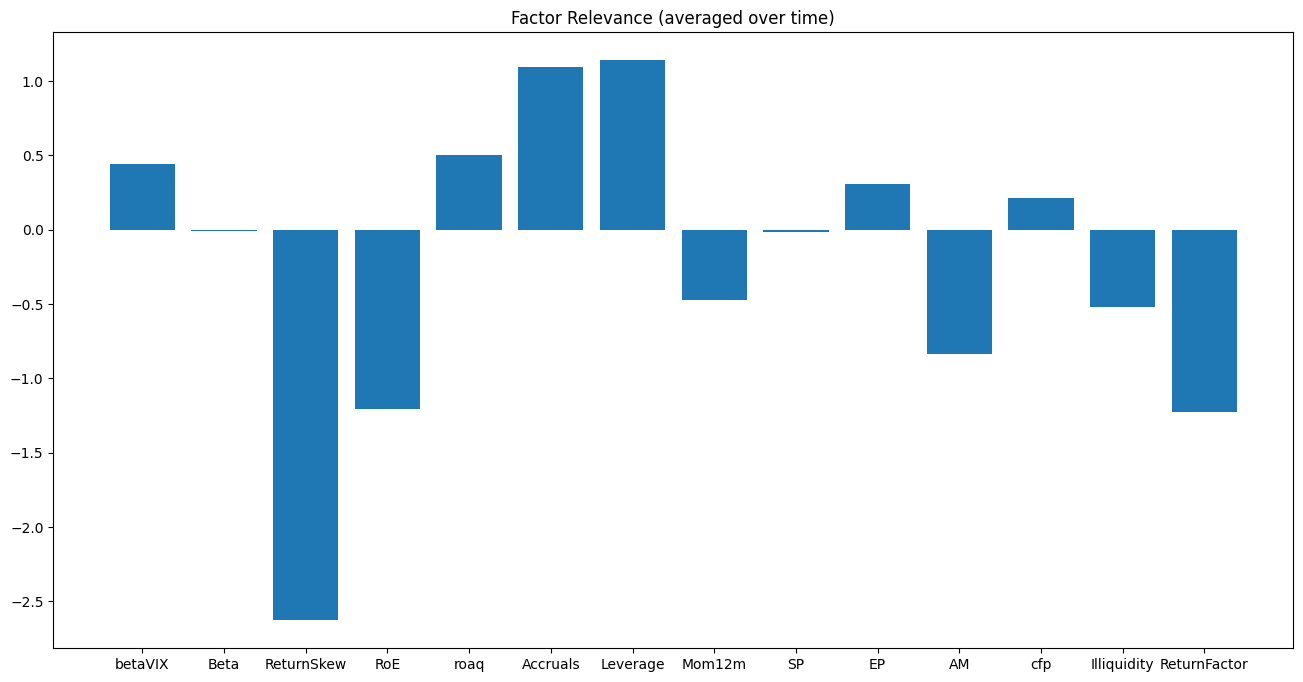

In [6]:
# Aggregate and Plot relevance over time

# Aggregate the relevance scores for all timesteps by taking the average
relevance_aggregated = np.mean(np.array(relevance), axis=1)


fig = go.Figure()

x = np.arange(relevance_aggregated.shape[0])  # Assume x-axis values are the same for all line plots

for i in range(relevance_aggregated.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=relevance_aggregated[:, i], mode='lines', name=(factor_selection + ["ReturnFactor"])[i]))
    
    
fig.update_layout(
    title='Multiple Line Plots',
    xaxis_title='Time',
    yaxis_title='Y-axis',
    legend_title='Lines'
)

fig.show()


plt.figure(figsize=(16,8))
plt.bar(height=relevance_aggregated.mean(axis=0), x=factor_selection + ["ReturnFactor"])
plt.title("Factor Relevance (averaged over time)")

# Fit a Rolling Linear Regression

In [11]:
# Define Path to File with factors
file_path = "./data/PredictorLSretWide.csv"

# Define which factor variables to use
factor_selection = ["betaVIX",
                "Beta",
                "ReturnSkew",
                "RoE",
                "roaq",
                "Accruals",
                "Leverage",
                "Mom12m",
                "SP",
                "EP",
                "AM",
                "cfp",
                "Illiquidity"]

# Produce a data set that includes all factors and the returns
sp500 = process_data_with_factors(file_path, factor_selection)


# Create lagged versions of the factors (lags 1, ..., lag 5)
lags = range(1, 2)

# save the old columns
old_columns = sp500.columns

# iterate over all columns and create 5 lags as new columns
for col in sp500.columns:
    for lag in lags:
        sp500[f'{col}_lag{lag}'] = sp500[col].shift(lag)

# remove contemporary features since we are intersted in predicting future returns by means of lag1, ..., lag5
sp500.drop(columns=old_columns[old_columns != "Return"], inplace=True)
sp500

Download data from yahoo finance ...
[*********************100%***********************]  1 of 1 completed
Download: DONE ✔️


,Return,Return_lag1,betaVIX_lag1,Beta_lag1,ReturnSkew_lag1,RoE_lag1,roaq_lag1,Accruals_lag1,Leverage_lag1,Mom12m_lag1,SP_lag1,EP_lag1,AM_lag1,cfp_lag1,Illiquidity_lag1,ReturnFactor_lag1
Date,,,,,,,,,,,,,,,,
1986-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-31,0.052794,NaN,-1.124098,2.040697,-0.209379,2.147633,1.230572,-2.165790,-0.864867,2.187365,2.277098,2.608961,0.364926,3.616018,-1.305286,NaN
1986-04-30,-0.014148,0.052794,2.196016,-0.259688,0.764894,0.808340,1.999448,0.508650,2.105713,2.419596,3.688215,0.785562,2.183969,1.490075,-0.237537,0.052794
1986-05-31,0.050229,-0.014148,-1.302264,1.015980,0.006036,0.674143,3.895225,-1.658995,-2.083530,2.429636,-0.638844,-0.441801,-1.455027,-0.881941,3.548422,-0.014148
1986-06-30,0.014110,0.050229,1.607945,-1.291977,-0.380737,0.376371,1.740396,2.650366,0.012491,3.721732,-0.066237,-2.718283,-0.720324,0.744781,-1.427658,0.050229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,0.022214,0.005486,2.631026,3.372760,0.320706,2.882669,4.480812,1.506504,9.070559,2.269053,10.585267,5.136591,9.948799,9.894074,0.811160,0.005486
2021-07-31,0.022748,0.022214,-11.382183,3.186146,-1.087748,-3.124938,-3.377943,1.811735,-5.888156,7.295195,-3.040112,-2.446702,-6.320181,-4.800265,0.681438,0.022214
2021-08-31,0.028990,0.022748,3.101351,-8.273075,4.429891,8.181131,14.738555,-1.818903,5.106772,2.759095,7.876313,-1.908708,4.953564,8.147565,-2.074692,0.022748


/tmp/ipykernel_294075/862346783.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  0%|          | 0/363 [00:00<?, ?it/s]

100%|██████████| 363/363 [00:00<00:00, 509.04it/s]


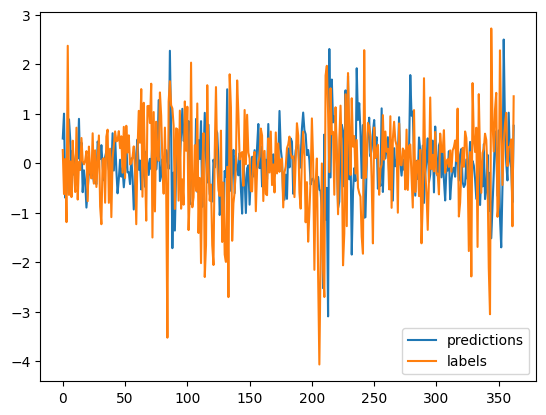

In [18]:
# import linear regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# define the data to train on - start from index 4 to make a comparison with LSTM model that can only use the same data
data = sp500.iloc[4:, :]

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


# Define the window size for the rolling regression
window_size = 60

# Perform the rolling regression
results = []
predictions = []
for i in tqdm(range(len(data) - window_size)):
    #print("i:i+window_size = ", i, i+window_size)
    window_data = data.iloc[i:i+window_size]
    model = sm.OLS(window_data.iloc[:, 0], window_data.iloc[:, 1:])
    result = model.fit()
    results.append(result)
    predictions.append(result.predict(data.iloc[i+window_size, 1:]))
    
plt.plot(np.array(predictions), label="predictions")
plt.plot(np.array(data.Return[60:]), label="labels")
plt.legend()

In [21]:
mse = np.mean((np.array(predictions) - np.array(data.Return[60:]))**2)
print("The MSE for the rolling regression:", mse)

The MSE for the rolling regression: 1.3337662807316941


In [20]:
print(len(predictions), len(np.array(data.Return[60:])))

363 363
